Data set: https://data.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load the data set into a pandas data frame
iowa_df = pd.read_csv("3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv")

# iowa_df.head(5) # Show the first 5 rows of the dataframe

In [3]:
# printing out unique values of a column
# iowa_df['Race - Ethnicity'].unique()

In [4]:
drop_row_list = ['White -', 'Black -', 'N/A -', np.nan]

iowa_clean_df = iowa_df[~iowa_df['Race - Ethnicity'].isin(drop_row_list)]


In [5]:
features_list = ['Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population']

features_df = iowa_clean_df[features_list]
# print(type(features_df))
labels_df = iowa_clean_df[['Return to Prison']]


In [6]:
# gets the ethnicity count and the gender count within each ethnicity group
ethnic_gender_series = iowa_clean_df.groupby(['Race - Ethnicity', 'Sex']).count()['Fiscal Year Released']
ethnic_gender_series

Race - Ethnicity                                 Sex   
American Indian or Alaska Native - Hispanic      Female        8
                                                 Male         12
American Indian or Alaska Native - Non-Hispanic  Female       95
                                                 Male        407
Asian or Pacific Islander - Hispanic             Male          5
Asian or Pacific Islander - Non-Hispanic         Female       21
                                                 Male        171
Black - Hispanic                                 Female        3
                                                 Male         34
Black - Non-Hispanic                             Female      634
                                                 Male       5475
White - Hispanic                                 Female      111
                                                 Male       1411
White - Non-Hispanic                             Female     2463
                                  

In [7]:
# separating list out by male and female to create stacked bar plot
female_count_list = []
male_count_list = []
for i in range(ethnic_gender_series.size):
    idx = i
    if (idx) % 2 == 0:
        male_count_list.append(ethnic_gender_series[idx])
    else:
        female_count_list.append(ethnic_gender_series[idx])
        
print(male_count_list)
print(female_count_list)

female_count_list.insert(2, 0)
print(female_count_list)

[8, 95, 5, 171, 34, 5475, 1411, 15121]
[12, 407, 21, 3, 634, 111, 2463]
[12, 407, 0, 21, 3, 634, 111, 2463]


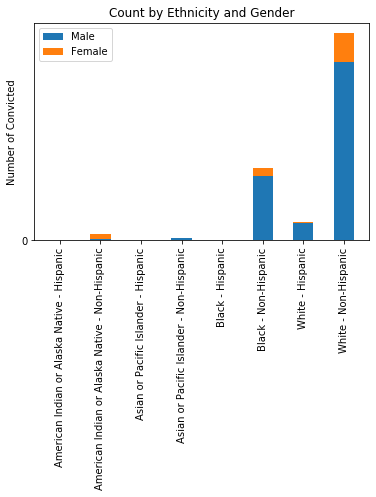

In [8]:
# create the stacked bar plot
width = 0.5
ind = np.arange(8) 

p1 = plt.bar(ind, male_count_list, width)
p2 = plt.bar(ind, female_count_list, width, bottom=male_count_list)

ethnic_list = ['American Indian or Alaska Native - Hispanic', \
               'American Indian or Alaska Native - Non-Hispanic', \
               'Asian or Pacific Islander - Hispanic', \
               'Asian or Pacific Islander - Non-Hispanic', \
               'Black - Hispanic', \
               'Black - Non-Hispanic', \
               'White - Hispanic', \
               'White - Non-Hispanic']


# ethnic_list = iowa_clean_df['Race - Ethnicity'].unique()

plt.title('Count by Ethnicity and Gender')
plt.ylabel('Number of Convicted')
plt.xticks(ind, ethnic_list, rotation=90)
plt.yticks(np.arange(0, 1000, 1000))
plt.legend((p1[0], p2[0]), ('Male', 'Female'))

plt.show()

split data set on race
- before train eliminate race column
- proxy variables that predict for race
- treat race as independent variable
  - predict race
- blindness != feature is gone

protected attributes

### Neural Network reference:
https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 <br>
https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24

In [9]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],4) 
        self.weights2   = np.random.rand(4,1)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)
    

(25971, 5)
(25971, 38)
--- Decision Tree: Recidivism Predictions Without Race ---
Accuracy: 0.6673724735322425
Precision: [0.67442794 0.50234742]
Recall: [0.9694172  0.06188548]
['No' 'Yes'] [4982, 213]


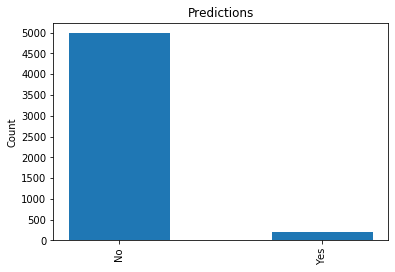

['No' 'Yes'] [3466, 1729]


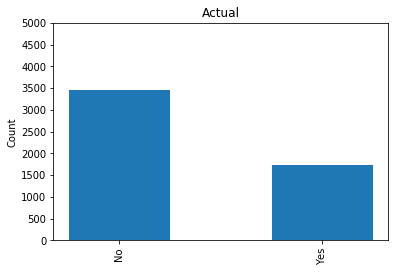

In [10]:
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import metrics

# le = preprocessing.LabelEncoder()
enc = preprocessing.LabelBinarizer()
copy = features_df
categorical_feature_mask = copy.dtypes==object
categorical_cols = copy.columns[categorical_feature_mask].tolist()
copy = copy.replace(np.nan, -1)
# copy = copy.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
print(copy.shape)
for entry in categorical_cols:
    copy.reset_index(drop=True, inplace=True)
    enc.fit(copy[entry].astype(str))
    transformed = enc.transform(copy[entry].astype(str))
#     print(transformed.shape, copy.shape, "Unqiues:", copy[entry].unique() )
    df = pd.DataFrame(transformed)
    copy = pd.concat([copy, df], axis=1).drop([entry], axis=1)
#     print("New size:",copy.shape)
print(copy.shape)
x_train, x_test, y_train, y_test = train_test_split(copy, labels_df, test_size=0.2, random_state=3)
index = -1
max = -1
for i in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train, y_train)
    y_hat = dt.predict(x_test)
    if (metrics.accuracy_score(y_test, y_hat) > max):
        max = metrics.accuracy_score(y_test, y_hat)
        index = i

dt = tree.DecisionTreeClassifier(max_depth=index)
dt.fit(x_train, y_train)
y_hat = dt.predict(x_test)
print("--- Decision Tree: Recidivism Predictions Without Race ---")
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))
print("Precision:",metrics.precision_score(y_test, y_hat, average=None, zero_division=1))
print("Recall:",metrics.recall_score(y_test, y_hat, average=None))

arr = np.unique(y_hat)
values = [0,0]
for entry in y_hat:
    for i in range(arr.size):
        if entry == arr[i]:
            values[i] += 1
print(arr, values)
width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()


arr2 = np.unique(y_test)
# print(arr2)
values2 = [0,0]
for entry in y_test.values:
#     print(entry)
    for i in range(arr2.size):
        if entry == arr2[i]:
            values2[i] += 1
print(arr2, values2)

width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values2, width)
plt.title('Actual')
plt.ylabel('Count')
plt.xticks(ind, arr2, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()


(25971, 6)
(25971, 46)
--- Decision Tree: Recidivism Predictions With Race ---
Accuracy: 0.6691049085659287
Precision: [0.6757899  0.52212389]
Recall: [0.96884016 0.06824754]
['No' 'Yes'] [4969, 226]


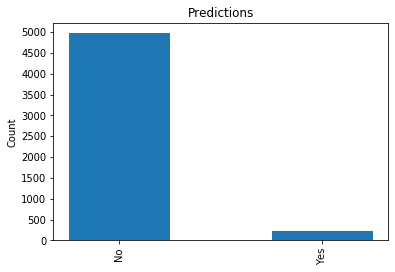

['No' 'Yes'] [3466, 1729]


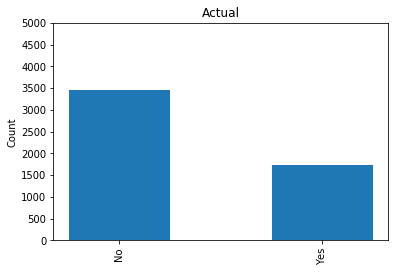

In [11]:
features_list3 = ['Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population', 'Race - Ethnicity']
features_df3 = iowa_clean_df[features_list3]
enc3 = preprocessing.LabelBinarizer()
copy3 = features_df3

categorical_feature_mask = copy3.dtypes==object
categorical_cols = copy3.columns[categorical_feature_mask].tolist()
# copy3 = copy3.replace(np.nan, -1)

print(copy3.shape)
for entry in categorical_cols:
    copy3.reset_index(drop=True, inplace=True)
    enc3.fit(copy3[entry].astype(str))
    transformed = enc3.transform(copy3[entry].astype(str))
    df = pd.DataFrame(transformed)
    copy3 = pd.concat([copy3, df], axis=1).drop([entry], axis=1)
print(copy3.shape)
x_train, x_test, y_train, y_test = train_test_split(copy3, labels_df, test_size=0.2, random_state=3)
index = -1
max = -1
for i in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train, y_train)
    y_hat = dt.predict(x_test)
    if (metrics.accuracy_score(y_test, y_hat) > max):
        max = metrics.accuracy_score(y_test, y_hat)
        index = i

dt = tree.DecisionTreeClassifier(max_depth=index)
dt.fit(x_train, y_train)
y_hat = dt.predict(x_test)
print("--- Decision Tree: Recidivism Predictions With Race ---")
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))
print("Precision:",metrics.precision_score(y_test, y_hat, average=None, zero_division=1))
print("Recall:",metrics.recall_score(y_test, y_hat, average=None))

arr = np.unique(y_hat)
values = [0,0]
for entry in y_hat:
    for i in range(arr.size):
        if entry == arr[i]:
            values[i] += 1
print(arr, values)
width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()


arr2 = np.unique(y_test)
# print(arr2)
values2 = [0,0]
for entry in y_test.values:
#     print(entry)
    for i in range(arr2.size):
        if entry == arr2[i]:
            values2[i] += 1
print(arr2, values2)

width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values2, width)
plt.title('Actual')
plt.ylabel('Count')
plt.xticks(ind, arr2, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()
    


(25971, 10)
(25971, 95)


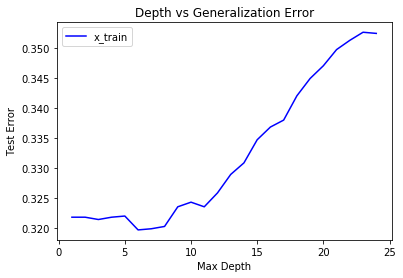

6
---Decision Tree: Race Predictions---
Accuracy: 0.6802694898941289
Precision: [1.         1.         1.         0.5        1.         0.54666667
 0.81818182 0.68178249]
Recall: [0.         0.         0.         0.05714286 0.         0.0329582
 0.05960265 0.99087019]
CM:  [[   0    0    0    0    0    0    0    5]
 [   0    0    0    0    0    0    0   94]
 [   0    0    0    0    0    0    0    1]
 [   0    0    0    2    0    0    2   31]
 [   0    0    0    0    0    0    0    9]
 [   0    0    0    1    0   41    1 1201]
 [   0    0    0    1    0    3   18  280]
 [   0    0    0    0    0   31    1 3473]]
['Asian or Pacific Islander - Non-Hispanic' 'Black - Non-Hispanic'
 'White - Hispanic' 'White - Non-Hispanic'] [4, 75, 22, 5094]


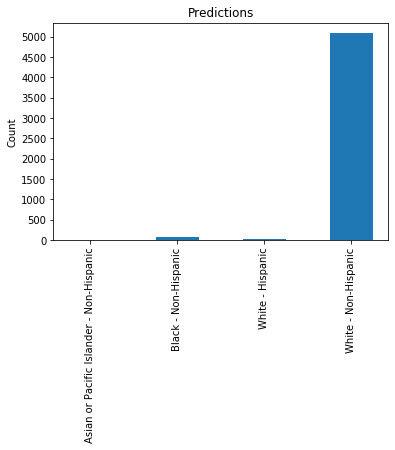

['American Indian or Alaska Native - Hispanic'
 'American Indian or Alaska Native - Non-Hispanic'
 'Asian or Pacific Islander - Hispanic'
 'Asian or Pacific Islander - Non-Hispanic' 'Black - Hispanic'
 'Black - Non-Hispanic' 'White - Hispanic' 'White - Non-Hispanic'] [5, 94, 1, 35, 9, 1244, 302, 3505]


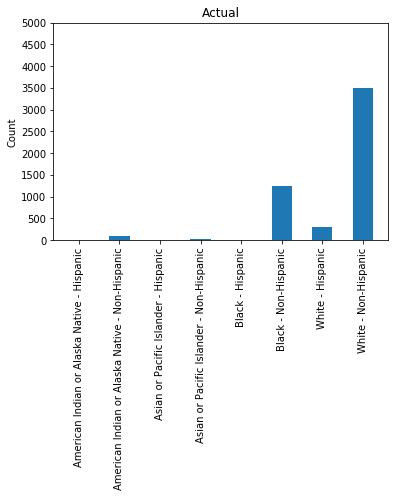

In [16]:
features_list2 = ['Return to Prison', 'New Offense Classification','New Offense Type', 'New Offense Sub Type', 'Recidivism Type', 'Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population']
features_df2 = iowa_clean_df[features_list2]
labels_df2 = iowa_clean_df[['Race - Ethnicity']]
# labels_df2 = labels_df2.replace(np.nan, "")


enc2 = preprocessing.LabelBinarizer()
copy2 = features_df2
categorical_feature_mask = copy2.dtypes==object
categorical_cols = copy2.columns[categorical_feature_mask].tolist()
copy2 = copy2.replace(np.nan, -1)
print(copy2.shape)

for entry in categorical_cols:
    copy2.reset_index(drop=True, inplace=True)
    enc2.fit(copy2[entry].astype(str))
    transformed = enc2.transform(copy2[entry].astype(str))
    df = pd.DataFrame(transformed)
    copy2 = pd.concat([copy2, df], axis=1).drop([entry], axis=1)
print(copy2.shape)

x_train, x_test, y_train, y_test = train_test_split(copy2, labels_df2, test_size=0.2, random_state= 3)

x_label = 'Max Depth'
y_label = 'Test Error'
plt.title('Depth vs Generalization Error')
plt.xlabel(x_label)
plt.ylabel(y_label)

index = -1;
max = -1;
err2 = [];
x_example = np.array(range(1,25));
for i in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train, y_train)
    y_hat = dt.predict(x_test)
    err2.append(1 - metrics.accuracy_score(y_test, y_hat));
    if (metrics.accuracy_score(y_test, y_hat) > max):
        max = metrics.accuracy_score(y_test, y_hat)
        index = i
plt.plot(x_example, err2, color='blue', label='x_train');
plt.legend()
plt.show()

print(index)

dt = tree.DecisionTreeClassifier(max_depth=index)
dt.fit(x_train, y_train)
y_hat = dt.predict(x_test)
print("---Decision Tree: Race Predictions---")
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))
print("Precision:",metrics.precision_score(y_test, y_hat, average=None, zero_division=1))
print("Recall:",metrics.recall_score(y_test, y_hat, average=None))
print("CM: ", metrics.confusion_matrix(y_test, y_hat, labels=ethnic_list))

plt.clf()
arr = np.unique(y_hat)
values = [0,0,0,0]
for entry in y_hat:
    for i in range(arr.size):
        if entry == arr[i]:
            values[i] += 1
print(arr, values)
width = 0.5
ind = np.arange(len(values)) 
p1 = plt.bar(ind, values, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))
plt.show()


arr2 = np.unique(y_test)
# print(arr2)
values2 = [0,0,0,0,0,0,0,0]
for entry in y_test.values:
#     print(entry)
    for i in range(arr2.size):
        if entry == arr2[i]:
            values2[i] += 1
print(arr2, values2)

width = 0.5
ind = np.arange(8) 
p1 = plt.bar(ind, values2, width)
plt.title('Actual')
plt.ylabel('Count')
plt.xticks(ind, arr2, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()
    



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from scipy import stats 
stats.chisqprob = lambda chisq, df:stats.chi2.sf(chisq, df)
import seaborn as sns
from scipy.special import expit
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
print(features_df.columns)
print(type(features_df))
features_df["Release Type"]=features_df["Release Type"].astype("category")
features_df["Age At Release "]=features_df["Age At Release "].astype("category")
features_df["Offense Classification"]=features_df["Offense Classification"].astype("category")
features_df["Offense Type"]=features_df["Offense Type"].astype("category")
features_df["Target Population"]=features_df["Target Population"].astype("category")
labels_df["Return to Prison"]=labels_df["Return to Prison"].astype("category")
le = preprocessing.LabelEncoder()
#print(type(features_df["Release Type"]))
features_df["Release Type"] = features_df["Release Type"].cat.codes
#features_df["Release Age "] = features_df["Release Age "].cat.codes
features_df['Age At Release '] = features_df['Age At Release '].cat.codes
features_df["Offense Classification"] = features_df["Offense Classification"].cat.codes
features_df["Offense Type"] = features_df["Offense Type"].cat.codes
features_df["Target Population"] = features_df["Target Population"].cat.codes 
le.fit(labels_df["Return to Prison"])
labels_df["Return to Prison"] = labels_df["Return to Prison"].cat.codes


x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.25, random_state=0)
list1 = y_test.index.tolist()
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)
plt.scatter(list1,predictions)
X_test = np.linspace(-5, 10,25000)
print(logisticRegr.coef_)
for i in x_test.index:
    plt.show()


# and plot the result







ModuleNotFoundError: No module named 'seaborn'